In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch
from matplotlib import pyplot as plt
import math
import torch.nn.functional as f
from torch.autograd import Variable
from sklearn.metrics import accuracy_score, precision_score, recall_score

# if on colab
#from google.colab import drive
#drive.mount('/content/gdrive')
#dir = '/content/gdrive/My Drive/ipz/'

# if locally
dir = ''

Mounted at /content/gdrive


In [29]:
classes = 2
d_model = 128
s_len_1 = 881
batch_size = 128
s_len_2 = 16712
n = 3
heads = 2
dropout = 0.1
device = 'cuda'

In [30]:
trunc_normal_correction = 0.87962566103423978

def fan_in(layer: nn.Linear):
    return layer.weight.size(1)


def fan_out(layer: nn.Linear):
    return layer.weight.size(0)


def linear_init_with_lecun_normal(layer: nn.Linear):
    stdev = math.sqrt(1 / fan_in(layer))/trunc_normal_correction
    nn.init.trunc_normal_(layer.weight.data,std = stdev)
    if layer.bias is not None:
        layer.bias.data.zero_()
    return layer


def linear_init_with_he_normal(layer: nn.Linear):
    stdev = math.sqrt(2 / fan_in(layer))/trunc_normal_correction
    nn.init.trunc_normal_(layer.weight.data,std = stdev)
    if layer.bias is not None:
        layer.bias.data.zero_()
    return layer


class PositionalEncoder(nn.Module):
    def __init__(self, max_seq_length, d_model, device):
        super().__init__()
        self.d_model = d_model
        self.device = device
        pe = torch.zeros(max_seq_length, d_model).to(device)
        for pos in range(max_seq_length):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                    math.sin(pos / (10000 ** ((2 * i) / d_model)))
                pe[pos, i + 1] = \
                    math.cos(pos / (10000 ** ((2 * (i + 1)) / d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x * math.sqrt(self.d_model)
        seq_len = x.size(1)
        x = x + Variable(self.pe[:, :seq_len], requires_grad=False).to(self.device)
        self.std = x.std()
        return x


class FeedForward(nn.Module):
    def __init__(self, d_model, device):
        super().__init__()
        self.device = device
        self.linear_1 = linear_init_with_he_normal(nn.Linear(d_model, 4 * d_model)).to(device)
        self.linear_2 = linear_init_with_lecun_normal(nn.Linear(4 * d_model, d_model)).to(device)

    def forward(self, x):
        x = f.relu(self.linear_1(x))
        x = self.linear_2(x)
        return x


def linear_init_with_glorot_uniform(layer: nn.Linear):
    scale = math.sqrt(6 / (fan_in(layer) + fan_out(layer)))
    layer.weight.data.uniform_(-scale, scale)
    if layer.bias is not None:
        layer.bias.data.zero_()
    return layer

def attention(q, k, v, d_k, device):
    heads = (torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)).to(device)
    heads = f.softmax(heads, dim=-1).to(device)
    scores = torch.matmul(heads, v).to(device)
    return scores, heads



class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, device):
        super().__init__()
        self.device = device
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        self.q_linear = linear_init_with_glorot_uniform(nn.Linear(d_model, d_model)).to(self.device)
        self.v_linear = linear_init_with_glorot_uniform(nn.Linear(d_model, d_model)).to(self.device)
        self.k_linear = linear_init_with_glorot_uniform(nn.Linear(d_model, d_model)).to(self.device)
        self.out = linear_init_with_lecun_normal(nn.Linear(d_model, d_model)).to(self.device)
        self.heads = None
        self.scores = None

    def forward(self, q, k, v):
        bs = q.size(0)

        # q,k,v ~ (batch, max_seq_length, d_model)
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k).to(self.device)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k).to(self.device)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k).to(self.device)

        # q,k,v ~ (batch, max_seq_length, h, d_k)
        k = k.transpose(1, 2)
        q = q.transpose(1, 2)
        v = v.transpose(1, 2)

        # q,k,v ~ (batch, h, max_seq_length, d_k)
        scores, heads = attention(q, k, v, self.d_k, self.device)

        # scores ~ (batch, h, max_seq_length, d_k)
        scores = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)

        # scores ~ (batch, max_seq_length, d_model)
        output = self.out(scores).to(self.device)
        # output ~ (batch, max_seq_length, d_model)

        if not self.training:
            self.heads = heads.detach()
            self.scores = scores.detach()

        return output


class Encoder(nn.Module):
    def __init__(self, s_len_1, s_len_2, d_model, n, heads, dropout, device):
        super().__init__()
        self.n = n
        self.device = device
        self.pe_1 = PositionalEncoder(s_len_1, d_model // 2, device)
        self.pe_2 = PositionalEncoder(s_len_2, d_model // 2, device)
        self.embed_1 = linear_init_with_he_normal(nn.Linear(s_len_1, d_model)).to(device)
        self.embed_2 = linear_init_with_he_normal(nn.Linear(s_len_2, d_model)).to(device)
        self.layers = nn.ModuleList([EncoderLayer(d_model, heads, dropout, device) for _ in range(n)])
        self.relu = nn.ReLU()

    def forward(self, x_1, x_2):
        x_1 = self.relu(self.embed_1(self.pe_1(x_1).transpose(1, 2)))
        x_2 = self.relu(self.embed_2(self.pe_2(x_2).transpose(1, 2)))
        x = torch.cat([x_1, x_2], dim=1)
        for i in range(self.n):
            x = self.layers[i](x)
        return x


class LayerNorm(nn.Module):
    def __init__(self, d_model, device, eps=1e-6):
        super().__init__()
        self.device = device
        self.size = d_model
        self.alpha = nn.Parameter(torch.ones(self.size).to(device))
        self.bias = nn.Parameter(torch.zeros(self.size).to(device))
        self.eps = eps

    def forward(self, x):
        norm = (self.alpha * (x - x.mean(dim=-1, keepdim=True))
                / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias).to(self.device)
        return norm


class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout, device):
        super().__init__()
        self.device = device
        self.norm_1 = LayerNorm(d_model, device)
        self.norm_2 = LayerNorm(d_model, device)
        self.attn = MultiHeadAttention(heads, d_model, device)
        self.ff = FeedForward(d_model, device)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.norm_1(x)
        x = x + self.dropout(self.attn(x, x, x))
        x = self.norm_2(x)
        x = x + self.dropout(self.ff(x))
        return x


class Model(nn.Module):
    def __init__(self, classes, d_model, s_len_1, s_len_2, n, heads, dropout, device):
        super().__init__()
        self.device = device
        self.n = n
        self.heads = heads
        self.d_model = d_model
        self.in1 = nn.Linear(1, d_model // 2).to(device)
        self.in2 = nn.Linear(1, d_model // 2).to(device)
        self.encoder = Encoder(s_len_1, s_len_2, d_model, n, heads, dropout, device)
        self.out1 = linear_init_with_he_normal(nn.Linear(d_model ** 2, d_model ** 2 // 4)).to(device)
        self.out2 = linear_init_with_he_normal(nn.Linear(d_model ** 2 // 4, d_model // 4 * classes)).to(device)
        self.out3 = linear_init_with_lecun_normal(nn.Linear(d_model // 4 * classes, classes)).to(device)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_1, x_2):
        x_1 = x_1.unsqueeze(-1)
        x_2 = x_2.unsqueeze(-1)
        x_1 = self.in1(x_1)
        x_2 = self.in1(x_2)
        x = self.encoder(x_1, x_2)
        x = x.view(-1, self.d_model ** 2)
        x = f.relu(self.out1(x))
        x = f.relu(self.out2(x))
        x = self.dropout(self.out3(x))
        return x


In [31]:
df_ic50 = pd.read_csv(dir + 'cleared_data/IC50_protein_compound_pair.tsv', delimiter='\t')
df_uniprot = pd.read_csv(dir + 'cleared_data/dpid_dom.tsv', delimiter='\t')
df_compound = pd.read_csv(dir + 'cleared_data/dcid_fingerprint.tsv', delimiter='\t')

df = df_ic50.merge(df_uniprot, on='DeepAffinity Protein ID', how='left')
df = df.merge(df_compound, on='DeepAffinity Compound ID', how='left')
df = df.iloc[:1000]
df['label'] = df['pIC50_[M]'] > 8
class_weights = torch.tensor([1 / len(df[~df["label"]]), 1 / len(df[df["label"]])],dtype=torch.float)
print(f'Positive pairs: {len(df[df["label"]])}  |  Negative pairs {len(df[~df["label"]])}')

X_train, X_test, y_train, y_test = train_test_split(df[['Domain Features', 'Fingerprint Feature']], df['label'], test_size=0.2, random_state=42)

Positive pairs: 225  |  Negative pairs 775


In [32]:
def str_to_series(x):
    return np.array(list(x)).astype('float32')

class MyDataset(Dataset):
  def __init__(self, x, y):
    self.x_1 = torch.tensor(np.stack(x['Fingerprint Feature'].map(str_to_series)))
    self.x_2 = torch.tensor(np.stack(x['Domain Features'].map(str_to_series)))
    self.y = torch.tensor(y.values, dtype=torch.long)

  def __len__(self):
    return len(self.y)

  def __getitem__(self,idx):
    return (self.x_1[idx], self.x_2[idx]), self.y[idx]

In [33]:
train_ds = MyDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_ds = MyDataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [34]:
model = Model(classes, d_model, s_len_1, s_len_2, n, heads, dropout, device)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [35]:
losses = pd.DataFrame()
epochs = 500
patience = 5
curr_patience = 5
min_valid_loss = np.inf

for e in range(epochs):
    train_loss = 0.0
    model.train()  # Optional when not using Model Specific layer
    for (x_1, x_2), labels in train_loader:
        optimizer.zero_grad()
        target = model(x_1.to(device), x_2.to(device))
        loss = criterion(target, labels.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    valid_loss = 0.0
    model.eval()
    for (x_1, x_2), labels in test_loader:
        target = model(x_1.to(device), x_2.to(device))
        loss = criterion(target, labels.to(device))
        valid_loss += loss.item()

    losses = pd.concat([losses, pd.DataFrame({'Train_Loss': train_loss / len(train_loader), 'Test_Loss': valid_loss / len(test_loader)}, index=[e])])

    print(f'E {e + 1}  |  Train Loss: {train_loss / len(train_loader) :.3f}  |  Test Loss: {valid_loss / len(test_loader) :.3f}')
    if min_valid_loss > valid_loss:
        min_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/gdrive/My Drive/ipz/best_model.pth')
        curr_patience = patience
    else:
        curr_patience -= 1
    if curr_patience == 0:
        break

E 1  |  Train Loss: 0.229  |  Test Loss: 0.145
E 2  |  Train Loss: 0.186  |  Test Loss: 0.121
E 3  |  Train Loss: 0.180  |  Test Loss: 0.114
E 4  |  Train Loss: 0.170  |  Test Loss: 0.109
E 5  |  Train Loss: 0.165  |  Test Loss: 0.105
E 6  |  Train Loss: 0.165  |  Test Loss: 0.100
E 7  |  Train Loss: 0.161  |  Test Loss: 0.098
E 8  |  Train Loss: 0.157  |  Test Loss: 0.094
E 9  |  Train Loss: 0.154  |  Test Loss: 0.089
E 10  |  Train Loss: 0.147  |  Test Loss: 0.087
E 11  |  Train Loss: 0.152  |  Test Loss: 0.085
E 12  |  Train Loss: 0.149  |  Test Loss: 0.083
E 13  |  Train Loss: 0.139  |  Test Loss: 0.083
E 14  |  Train Loss: 0.146  |  Test Loss: 0.083
E 15  |  Train Loss: 0.149  |  Test Loss: 0.083
E 16  |  Train Loss: 0.135  |  Test Loss: 0.084
E 17  |  Train Loss: 0.150  |  Test Loss: 0.083
E 18  |  Train Loss: 0.150  |  Test Loss: 0.085
E 19  |  Train Loss: 0.143  |  Test Loss: 0.082
E 20  |  Train Loss: 0.142  |  Test Loss: 0.087
E 21  |  Train Loss: 0.143  |  Test Loss: 0.086
E

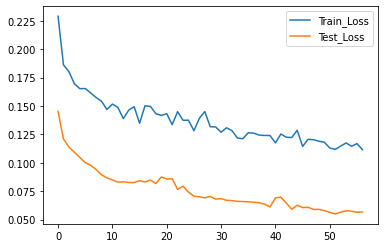

In [36]:
losses.plot()
plt.show()

In [37]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/ipz/best_model.pth'))
model.eval()

y, y_ = [], []

for (x_1, x_2), labels in test_loader:
    target = model(x_1.to(device), x_2.to(device))
    y_.extend(target.detach().cpu().numpy()[:, 1] > 0.5)
    y.extend(labels.detach().cpu().numpy())
print(f'Accuracy: {accuracy_score(y, y_)}  |  Precision {precision_score(y, y_)}  |  Recall {recall_score(y, y_)}')

Accuracy: 0.915  |  Precision 0.7884615384615384  |  Recall 0.8723404255319149
